In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../PI_GP_regressor')

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_wave_3d import gram_Matrix,k_ff, k_fu, k_uf, k_uu

 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


(320, 3)


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


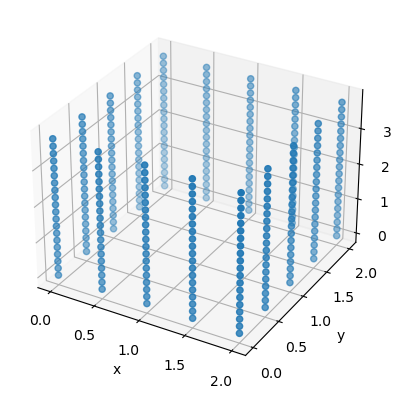

(400, 3)
(400, 1)


In [2]:
kernel_list = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
hyperparameters = ["l_space", "sigma", "l_t", "c"]
model = PhysicsInformedGP_regressor(kernel_list, params = hyperparameters,timedependence=True, Dimensions = 3)

n_training_points = 400

model.set_training_data("",n_training_points, noise = [1e-8,1e-8])
model.set_validation_data(1000)

# here we add extra boundary points to the training data to enforce the boundary conditions
boundary_points_space = np.array([[0,0],[2,2],[0,2],[2,0],[0,1],[1,0],
                                  [1,2],[2,1],[0.5,0],[0.5,2],[0,0.5],
                                  [2,0.5],[0,1.5],[2,1.5],[1.5,0],[1.5,2]])

t_points = np.arange(0,4,0.2)
boundary_points_all = []
for t in t_points:
    boundary_points_all.append(np.hstack((boundary_points_space,t*np.ones((len(boundary_points_space),1)))))
boundary_points_all = np.vstack(boundary_points_all)
print(boundary_points_all.shape)
#model.X_u = np.vstack((model.X_u,boundary_points_all))
#model.targets = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1)),model.f_train))
#model.u_train = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1))))

#plot of the boundary points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(boundary_points_all[:,0],boundary_points_all[:,1],boundary_points_all[:,2])
#ax.scatter(model.X_u_test[:,0],model.X_u_test[:,1],model.X_u_test[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()
print(model.X_u.shape)
print(model.u_train.shape)





Optimization with gradient based optimizers. Possible choices are "L-BFGS-B", "CG", "TNC"

In [39]:
model.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    #theta_initial[0] = rng.uniform(0, 1.2, 1)               #slx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-4, -2, 1))  #lt
    #theta_initial[2] = rng.uniform(0, 1.2, 1)               #slt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial
n_restarts = 1000
n_threads = 2
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-7}
model.train("Nelder-Mead",n_restarts, n_threads,opt_params_dict)

100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Theta:  [0.05984425 0.73049449 6.65110501 0.04593947] 
 Log marginal likelihood:  -517.3462524414062


Optimization via baysian optimization 

In [45]:
from skopt import gp_minimize, forest_minimize
from skopt.space import Real
model.jitter = 1e-6
def gaussian_optimization(dictionary: dict, rs):
    results = []
    def objective_function(params):
        l_x, sigma_f_sq, l_t, alpha = params
        return model.log_marginal_likelohood(params).item()
    for i in range(1,35):
        try:
            result = gp_minimize(objective_function,
                         random_state=int(i)*np.random.randint(0,300), **dictionary)
            print(f"GP worked rs{i} ", result.fun, result.x)
            results.append((result.x, result.fun))
        except:
            continue

    
    return results

ranges = [Real(0,1, name='l_x', prior="uniform"),
             Real(0, 1, name='sigma_f_sq', prior="uniform"),
             Real(0, 1, name='l_t', prior="uniform"),
             Real(0, 2, name='c', prior="uniform")]
bays_opt_dictionary = {'dimensions': ranges,
                        'n_calls': 45,
                        'n_initial_points': 30,
                        'verbose': None,
                        'noise': 1e-5,
                        'n_jobs': 3                       
                        }
result = gaussian_optimization(bays_opt_dictionary,1)


GP worked rs15  -186.459228515625 [0.2797329205710794, 0.3392912138720236, 0.806910065081306, 0.9021482035197723]
GP worked rs18  -201.75927734375 [0.053878163263627724, 0.018037812541435553, 0.8108754342373071, 0.23068323731931556]
GP worked rs24  -289.56689453125 [0.17418237366395448, 0.29917404773946377, 0.8528291067152579, 0.0]
GP worked rs28  -242.92486572265625 [0.551817839672976, 0.6641834824612896, 0.7044301471379859, 1.0302560475575395]


In [9]:
best_result = min(result, key = lambda x: x[1])
print(best_result)

([0.3057155258953946, 0.21726992644012016, 0.4966331472307953, 0.6305949623457213], -120.50244140625)


In [62]:
model.set_params([0.49959606732247214, 0.09878584827177633, 0.41479573778840956, 0.9925657694949922])
model.set_params([0.4754524756028119, 0.20084881403865779, 0.32547264542720733, 0.9962710869284501]) #-390
#-597.0882568359375 [0.48837444094640414, 0.5619550832159071, 0.4893737892708073, 1.0081860224676764]
#model.set_params([0.48837444094640414, 0.5619550832159071, 0.4893737892708073, 1.0081860224676764]) #-119
model.set_params([0.6334306537333778, 0.5144069340069019, 0.22517997521578453, 1.0006342478426848]) #-132.055419921875 
#GP worked rs219  -667.454833984375 [0.571053577064954, 0.6093703667107739, 0.3926133066463453, 0.9974625467476019]
model.set_params([0.5772818438911846, 0.336497412354715, 0.3451654017103214, 0.9974850845470475]) #GP worked rs199  -650.428955078125
model.set_params([0.5750073101202368, 0.36639797198403085, 0.486647066974093, 1.0008704250979434]) #GP worked rs138  -973.806884765625
#model.set_params([0.6, 0.3522058296204479, 0.5, 1.00150328538452])# 100 data points wiht boundary points -227.667724609375
model.set_params([ 6.201e-01,  3.723e-01,  5.319e-01,  9.999e-01])# 100 data points wiht boundary points -456 #400 without boundary

Here we calculate the predictive mean and variance for test points in the domain x[0,2] y[0,2] t[0,4]

In [63]:
grid_number = 101
x = np.linspace(0,2,grid_number).reshape(-1,1)
y = np.linspace(0,2,grid_number).reshape(-1,1)
t = np.linspace(0,4,grid_number).reshape(-1,1)
gx, gy = np.meshgrid(x,y)

X_2d = np.c_[gx.ravel(), gy.ravel()]

time_points = np.linspace(0,4,81)


In [66]:
model.jitter = 1e-6
mean = []
var = []
for i in range(len(time_points)):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = model.predict_u(X_3d)
    mean.append(mean_i)
    var.append(var_i)
    
from matplotlib.animation import FuncAnimation
mean = np.array(mean)
mean = mean.reshape(len(time_points),grid_number,grid_number)
u_matrix = model.raw_data[2]
print(mean.shape)

(81, 101, 101)


In [65]:
model.jitter = 1e-6
mean, var = model.predict_u(model.X_u_test)
rel_l2 = model.relative_l2_error
rel_l2(mean, model.u_test)

0.0071913945

With the predictive mean we can now calculate the the realtive L2 error

Text(0.5, 0, 't')

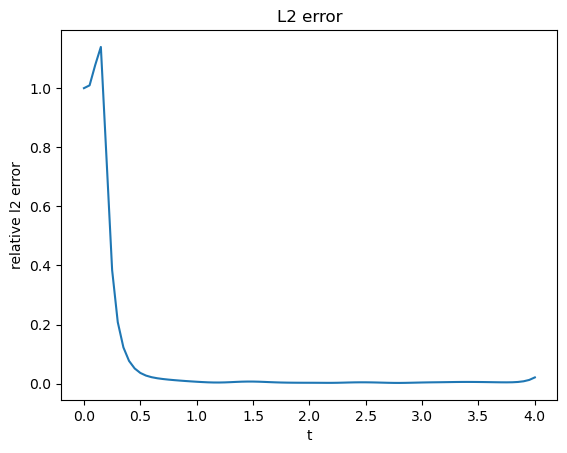

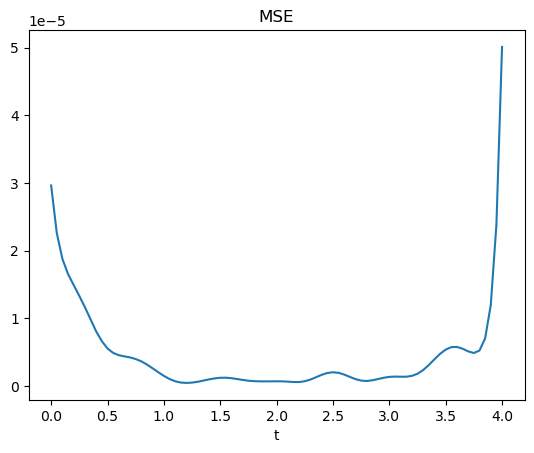

In [67]:
rel_l2 = model.relative_l2_error #internal function that calculates the relative for 2 given matrices
l2_error = []
MSe = []
for i in range(len(time_points)):
    l2_error.append(rel_l2(mean[i,:,:],u_matrix[:,:,i]))
    MSe.append(np.mean((mean[i,:,:]-u_matrix[:,:,i])**2))
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('L2 error')
ax.plot(time_points,l2_error)
ax.set_xlabel('t')
ax.set_ylabel('relative l2 error')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('MSE')

ax.plot(time_points,MSe)
ax.set_xlabel('t')


In [68]:
print("MSE = ", np.mean((mean[:,:,:].ravel() - u_matrix[:,:,:].ravel())**2).item())

MSE =  0.15130497518492472


In [69]:
print("rel L2 error = ",rel_l2(mean[:,:,:],u_matrix[:,:,:].T))

rel L2 error =  0.007927749988381024


Here we create plots/mp4 for the visualization of the prediction and the ground truth.

In [70]:
fig, ax  = plt.subplots(1,2,figsize=(10,5))
#fig.tight_layout()
def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
    fig.suptitle(f't = ' + f"{time_points[i]:.2f}", fontsize=16)
    ax[0].clear()
    im = ax[0].imshow(mean[i,:,:].T, cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[0].set_title("mean")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[1].clear()
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    im = ax[1].imshow(u_matrix[:,:,i], cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[1].set_title("ground truth")
    
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('movie files/heatmap_plot.gif', writer='ffmpeg', fps=10)
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [71]:
fig, ax  = plt.subplots(1,2,figsize = (12,6), subplot_kw={"projection": "3d"})

def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
        a.set_zlabel('t')
    fig.suptitle('t = ' + f"{time_points[i]:.2f}", fontsize=12)
    ax[0].clear()
    im = ax[0].plot_surface(gx,gy,mean[i,:,:].T, cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[0].set_title("mean")
    ax[0].set_zlim(-0.8,0.8)

    ax[1].clear()
    im = ax[1].plot_surface(gx,gy,u_matrix[:,:,i], cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[1].set_title("ground truth")
    ax[1].set_zlim(-0.8,0.8)
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('movie files/3dplot_400.gif', writer='ffmpeg', fps=10,dpi = 200)
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


(101, 101, 81)


NameError: name 'mean' is not defined

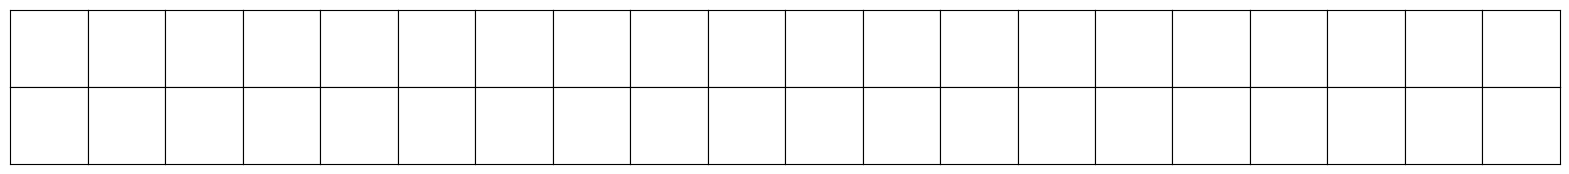

In [13]:
fig, ax = plt.subplots(2,20,figsize=(20,2),sharey=True,sharex=True)
fig.subplots_adjust(hspace=0., wspace=0.)
#no axis ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
ax = ax.flatten()
#title for the second row at the left side

#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    ax_1[i].imshow(mean[i*4+4,:,:], cmap='viridis',extent=[0,2,0,2],vmin = -0.5, vmax = 0.5)
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4+4],4)), fontsize=12)
    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    
    im = ax_2[i].imshow(u_matrix[:,:,i*4+4].T, cmap='viridis',extent=[0,2,0,2],vmin = -0.5, vmax = 0.5)

# Add titles to the first row and second row
fig.text(0.5, 0.98, '(a) Mean', ha='center', fontsize=13)
fig.text(0.5, 0.46, '(b) Ground Truth', ha='center', fontsize=13)
#add space between rows
fig.subplots_adjust(hspace=0.75)

#fig.tight_layout()

#plt.savefig('heatmap_grid.png', dpi=300, bbox_inches='tight')

(101, 101, 81)


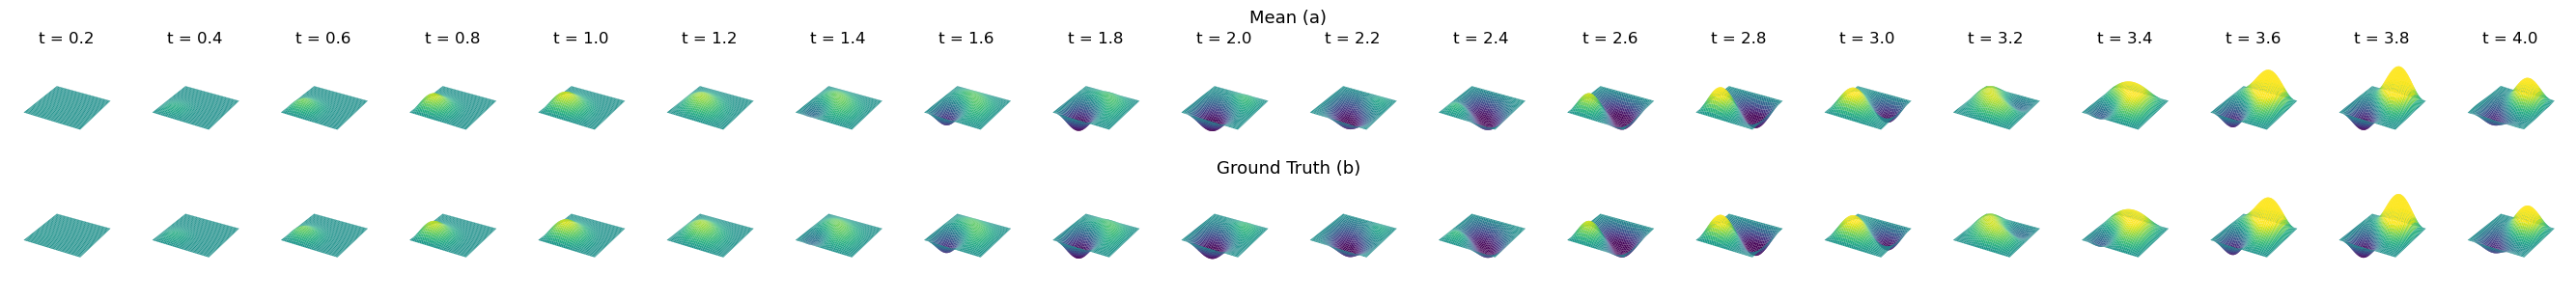

In [46]:
fig, ax = plt.subplots(2,20,figsize=(27,3),subplot_kw={"projection": "3d"})
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(0,20),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    im = ax_1[i].plot_surface(gx,gy,mean[i*4+4,:,:], cmap='viridis',vmin = -0.6, vmax = 0.6)
    ax_1[i].axis('off')
    ax_1[i].set_zlim(-0.8,0.8)
    ax_2[i].set_zlim(-0.8,0.8)

    im = ax_2[i].plot_surface(gx,gy,u_matrix[:,:,i*4+4], cmap='viridis',vmin = -0.6, vmax = 0.6)
    ax_2[i].axis('off')

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4+4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()
fig.text(0.5, 0.98, 'Mean (a)', ha='center', fontsize=13)
fig.text(0.5, 0.46, 'Ground Truth (b)', ha='center', fontsize=13)
#add space between rows

plt.savefig('3dsurface_grid.png', dpi=300, bbox_inches='tight')

In [72]:
var = np.array(var)
var = var.reshape(len(time_points),grid_number,grid_number)
std = np.sqrt(var)

 C:\Users\leitg\AppData\Local\Temp\ipykernel_125824\2514870824.py:3: RuntimeWarning:invalid value encountered in sqrt


(101, 101, 81)


 C:\Users\leitg\AppData\Local\Temp\ipykernel_125824\3577135333.py:19: UserWarning:The figure layout has changed to tight


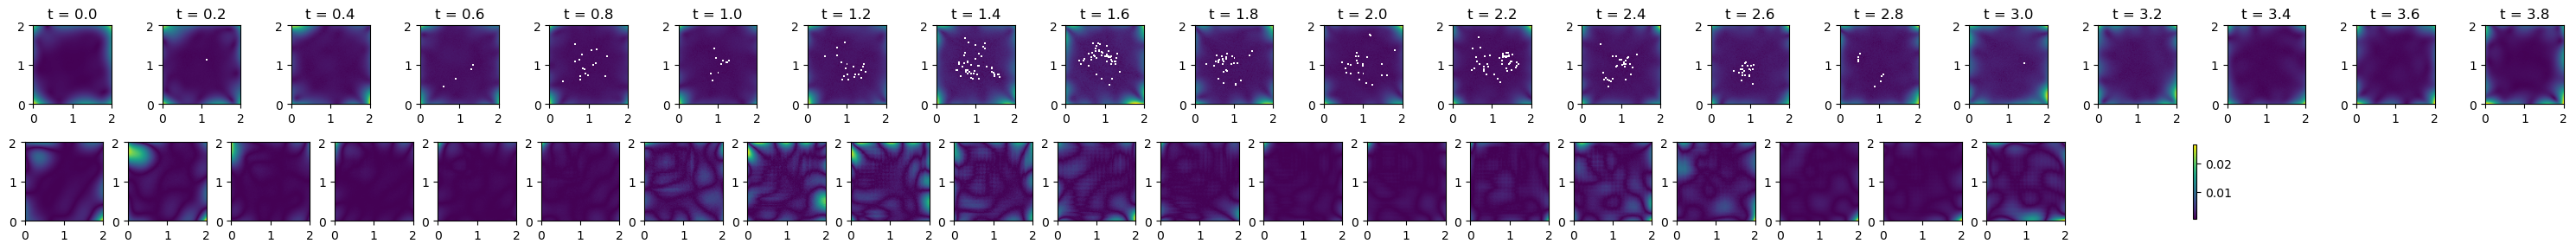

In [73]:
fig, ax = plt.subplots(2,20,figsize=(30,3))
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 4, len(u_matrix[0,0,:]))):
    
    im = ax_1[i].imshow(std[i*4,:,:].T, cmap='viridis',extent=[0,2,0,2])
    #plot the train points. we need to chekck for every t value and then plot the x,y coordinates
    #ax[i].scatter(x_train_u[t_train_u==i*5], y_train_u[t_train_u==i*5], color='red', marker='x', label='training points')
    ax_2[i].imshow(np.abs(mean[i*4,:,:]-u_matrix.T[i*4,:,:]), cmap='viridis',extent=[0,2,0,2])

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()
fig.colorbar(im, ax=ax_2.ravel().tolist(), shrink=0.95)

In [ ]:
import GPy
kernel = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=1., ARD = False)
X_train = model.X_u
X_train = np.array(X_train)
Y_train = model.u_train
Y_train = np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)
m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize_restarts(num_restarts = 10)

In [72]:
mean, var = m.predict(model.X_u_test)
rel_l2 = model.relative_l2_error
rel_l2(mean, model.u_train_test)

0.12795584746549055

In [56]:
mean_gpy = []
var_gpy = []
for i in range(len(time_points)):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = m.predict(X_3d)
    mean_gpy.append(mean_i)
    var_gpy.append(var_i)
mean_gpy = np.array(mean_gpy)
mean_gpy = mean_gpy.reshape(len(time_points),grid_number,grid_number)
u_matrix = model.raw_data[2]
print(mean.shape)

(1000, 1)


MSE =  0.07806501552804107
rel L2 error =  5.139509149925408


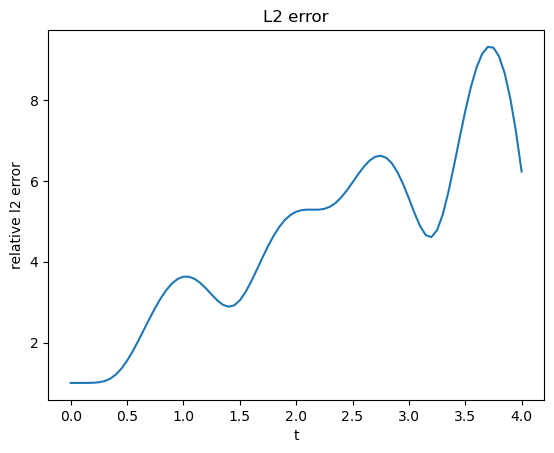

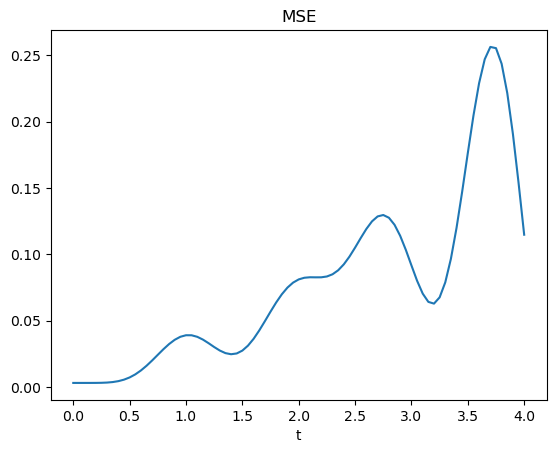

In [57]:
rel_l2 = model.relative_l2_error #internal function that calculates the relative for 2 given matrices
l2_error = []
MSe = []
for i in range(len(time_points)):
    l2_error.append(rel_l2(mean_gpy[i,:,:],u_matrix[:,:,i]))
    MSe.append(np.mean((mean_gpy[i,:,:]-u_matrix[:,:,i])**2))
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('L2 error')
ax.plot(time_points,l2_error)
ax.set_xlabel('t')
ax.set_ylabel('relative l2 error')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('MSE')

ax.plot(time_points,MSe)
ax.set_xlabel('t')

print("MSE = ", np.mean((mean_gpy[:,:,:].ravel() - u_matrix[:,:,:].ravel())**2).item())
print("rel L2 error = ",rel_l2(mean_gpy[:,:,:],u_matrix[:,:,:].T))


In [94]:
fig, ax  = plt.subplots(1,2,figsize=(10,5))
def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
    fig.suptitle(f't = ' + f"{time_points[i]:.2f}", fontsize=16)
    ax[0].clear()
    im = ax[0].imshow(mean_gpy[i,:,:].T, cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[0].set_title("mean")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[1].clear()
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    im = ax[1].imshow(u_matrix[:,:,i], cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[1].set_title("ground truth")

ani = FuncAnimation(fig, frame, frames=80, repeat=False)

ani.save('movie files/heatmap_plot_gpy_100.gif', writer='ffmpeg', fps=10)
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [107]:
fig, ax  = plt.subplots(1,2,figsize = (12,6), subplot_kw={"projection": "3d"})

def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
        a.set_zlabel('t')
    fig.suptitle('t = ' + f"{time_points[i]:.2f}", fontsize=12)
    ax[0].clear()
    im = ax[0].plot_surface(gx,gy,mean_gpy[i,:,:].T, cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[0].set_title("mean")
    ax[0].set_zlim(-0.8,0.8)

    ax[1].clear()
    im = ax[1].plot_surface(gx,gy,u_matrix[:,:,i], cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[1].set_title("ground truth")
    ax[1].set_zlim(-0.8,0.8)
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('movie files/3dplot_gpy_100.gif', writer='ffmpeg', fps=10,dpi = 200)
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [3]:
import GPy#
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    #theta_initial[0] = rng.uniform(0, 1.2, 1)               #slx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-4, -2, 1))  #lt
    #theta_initial[2] = rng.uniform(0, 1.2, 1)               #slt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial

opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                        'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                        'gtol': 1e-7}

errors_pim = []
model_params_pim = []
errors_gpy = []
model_params_gpy = []
def run_model_and_gpy_model(n_training_points):
    model = PhysicsInformedGP_regressor(kernel_list, params = hyperparameters,timedependence=True, Dimensions = 3)
    model.jitter = 1e-6
    boundary_points_space = np.array([[0,0],[2,2],[0,2],[2,0],[0,1],[1,0],
                                  [1,2],[2,1],[0.5,0],[0.5,2],[0,0.5],
                                  [2,0.5],[0,1.5],[2,1.5],[1.5,0],[1.5,2]])
    model.set_training_data("",n_training_points, noise = [1e-8,1e-8])
    model.set_validation_data(2000)
    t_points = np.arange(0,4,0.2)
    boundary_points_all = []
    for t in t_points:
        boundary_points_all.append(np.hstack((boundary_points_space,t*np.ones((len(boundary_points_space),1)))))
    boundary_points_all = np.vstack(boundary_points_all)
   
    #model.X_u = np.vstack((model.X_u,boundary_points_all))
    #model.targets = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1)),model.f_train))
    #model.u_train = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1))))
    
    n_restarts = 150
    n_threads = 3
    
    model.train("TNC",n_restarts, n_threads,opt_params_dict)
    model_params_pim.append(model.get_params())

    # # grid_number = 101
    # # x = np.linspace(0,2,grid_number).reshape(-1,1)
    # # y = np.linspace(0,2,grid_number).reshape(-1,1)
    # # t = np.linspace(0,4,grid_number).reshape(-1,1)
    # # gx, gy = np.meshgrid(x,y)

    # # X_2d = np.c_[gx.ravel(), gy.ravel()]

    # # time_points = np.linspace(0,4,81)

    # # mean = []
    # # var = []
    # # for i in range(len(time_points)):
    # #     X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    # #     mean_i, var_i = model.predict_u(X_3d)
    # #     mean.append(mean_i)
    # #     var.append(var_i)
        
    mean, var = model.predict_u(model.X_u_test)
    rel_l2 = model.relative_l2_error
    error = rel_l2(mean, model.u_test)
    errors_pim.append(error)
    print("PIM error:", error)

    #GPY
    


    kernel = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=1., ARD = False)
    X_train = model.X_u
    X_train = np.array(X_train)
    Y_train = model.u_train
    Y_train = np.array(Y_train)
    
    m = GPy.models.GPRegression(X_train, Y_train, kernel)
    m.optimize_restarts(num_restarts = 10)
    mean_gpy, var_gpy = m.predict(model.X_u_test)
    error = rel_l2(mean_gpy, model.u_test)
    errors_gpy.append(error)
    
    mean_gpy = np.array(mean_gpy)
    
    print("n:",n_training_points, "l2_error:", error)

In [4]:
n = [50,100,125,150,200,250,300,350,400]
for n_points in n:
    run_model_and_gpy_model(n_points)

 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 71.32159423828125
       x: [ 5.018e-01  1.645e-01  4.266e-01  8.849e-01]
     nit: 12
     jac: [ 3.269e-01 -1.969e-01  1.490e-01 -1.318e-01]
    nfev: 97
PIM error: 0.3816205
Optimization restart 1/10, f = 3.7083972477152827
Optimization restart 2/10, f = 3.7083972477151015
Optimization restart 3/10, f = 10.862003003575506
Optimization restart 4/10, f = 3.708397247714302
Optimization restart 5/10, f = 10.862080049085488
Optimization restart 6/10, f = 3.7083972477203133
Optimization restart 7/10, f = 3.7083972477170484
Optimization restart 8/10, f = 10.862003973568605
Optimization restart 9/10, f = 10.862006457977163
Optimization restart 10/10, f = 3.708397247714249
n: 50 l2_error: 0.6403071320126037


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [01:22<00:00,  1.81it/s]


 message: Converged (|x_n-x_(n-1)| ~= 0)
 success: True
  status: 2
     fun: 99.52983093261719
       x: [ 6.170e-01  2.818e-01  4.954e-01  9.995e-01]
     nit: 17
     jac: [ 1.089e+01 -3.675e+00  7.986e+00 -5.914e+00]
    nfev: 96
PIM error: 0.14851604
Optimization restart 1/10, f = -25.678540390006646
Optimization restart 2/10, f = -25.678548475243304
Optimization restart 3/10, f = -25.678547338916538
Optimization restart 4/10, f = 13.85110143897775
Optimization restart 5/10, f = 13.762375041146122
Optimization restart 6/10, f = -25.678548465082663
Optimization restart 7/10, f = 13.762468196083752
Optimization restart 8/10, f = -25.678534125522425
Optimization restart 9/10, f = -25.678548479670873
Optimization restart 10/10, f = -25.678546324021553
n: 100 l2_error: 0.20213737679525523


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [01:25<00:00,  1.76it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 95.97352600097656
       x: [ 6.226e-01  3.249e-01  5.205e-01  1.006e+00]
     nit: 13
     jac: [ 3.546e-01  2.116e-01 -1.093e+00  1.231e+01]
    nfev: 93
PIM error: 0.093698
Optimization restart 1/10, f = -54.98262572136345
Optimization restart 2/10, f = -54.9826535464399
Optimization restart 3/10, f = -54.98265437027878
Optimization restart 4/10, f = -54.982654298722075
Optimization restart 5/10, f = -54.982654438818514
Optimization restart 6/10, f = -54.98265437795319
Optimization restart 7/10, f = -54.982616271293445
Optimization restart 8/10, f = -54.982649779234
Optimization restart 9/10, f = 15.71774888460643
Optimization restart 10/10, f = -54.982654422317985
n: 125 l2_error: 0.16102126228662497


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [01:42<00:00,  1.47it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 82.26312255859375
       x: [ 6.237e-01  2.819e-01  5.054e-01  1.010e+00]
     nit: 9
     jac: [ 6.502e+00 -1.974e+01  1.335e+01  2.290e+01]
    nfev: 82
PIM error: 0.079064004
Optimization restart 1/10, f = 13.496186238632305
Optimization restart 2/10, f = -97.0637152612097
Optimization restart 3/10, f = -97.06356930170554
Optimization restart 4/10, f = -97.0636722460136
Optimization restart 5/10, f = 13.433019150210242
Optimization restart 6/10, f = -97.06369142055254
Optimization restart 7/10, f = -97.06371926389697
Optimization restart 8/10, f = -97.063715778632
Optimization restart 9/10, f = -97.06371309285518
Optimization restart 10/10, f = -97.06371928820052
n: 150 l2_error: 0.1462099419558687


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [01:45<00:00,  1.42it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 33.05082702636719
       x: [ 6.376e-01  3.952e-01  5.098e-01  1.001e+00]
     nit: 10
     jac: [-2.027e+00  4.627e+00 -2.797e+01  1.998e+00]
    nfev: 93
PIM error: 0.043063294
Optimization restart 1/10, f = -193.07078127495933
Optimization restart 2/10, f = -193.07078133569573
Optimization restart 3/10, f = -193.07078003005222
Optimization restart 4/10, f = -193.0707800393714
Optimization restart 5/10, f = -193.0707644030296
Optimization restart 6/10, f = -193.07078111114376
Optimization restart 7/10, f = -193.07078120586715
Optimization restart 8/10, f = -193.07078112139232
Optimization restart 9/10, f = -193.07075965449962
Optimization restart 10/10, f = -193.0707812791041
n: 200 l2_error: 0.10798810422204357


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [02:19<00:00,  1.08it/s]


 message: Converged (|x_n-x_(n-1)| ~= 0)
 success: True
  status: 2
     fun: -51.83509826660156
       x: [ 6.351e-01  3.987e-01  5.158e-01  9.998e-01]
     nit: 13
     jac: [ 6.891e+00 -8.258e+00 -1.698e+01  4.274e+01]
    nfev: 66
PIM error: 0.025923083
Optimization restart 1/10, f = -306.3467643298169
Optimization restart 2/10, f = -306.3467593049493
Optimization restart 3/10, f = -306.34660958515826
Optimization restart 4/10, f = -306.3466714342682
Optimization restart 5/10, f = -306.3466284606672
Optimization restart 6/10, f = -306.34676431423105
Optimization restart 7/10, f = -306.3467506443948
Optimization restart 8/10, f = -306.346763148454
Optimization restart 9/10, f = -306.3467700834555
Optimization restart 10/10, f = -306.34677306385464
n: 250 l2_error: 0.07105669736517982


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [02:48<00:00,  1.12s/it]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -166.74725341796875
       x: [ 6.198e-01  3.466e-01  5.270e-01  9.997e-01]
     nit: 14
     jac: [ 1.169e+01 -4.830e+01  3.800e+01  5.769e+01]
    nfev: 92
PIM error: 0.0133060925
Optimization restart 1/10, f = -468.5991803409084
Optimization restart 2/10, f = -468.59918414982286
Optimization restart 3/10, f = -468.5991790371752
Optimization restart 4/10, f = -468.5991847116981
Optimization restart 5/10, f = -468.59917825962924
Optimization restart 6/10, f = -468.5991833263321
Optimization restart 7/10, f = -468.59918311641036
Optimization restart 8/10, f = -468.599148540272
Optimization restart 9/10, f = -468.59916900224835
Optimization restart 10/10, f = -468.59918352036664
n: 300 l2_error: 0.06353820874803118


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [03:20<00:00,  1.34s/it]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -299.78106689453125
       x: [ 6.179e-01  2.818e-01  5.003e-01  9.998e-01]
     nit: 13
     jac: [-2.338e+01 -6.481e+01 -1.436e+02  2.880e+01]
    nfev: 98
PIM error: 0.010207459
Optimization restart 1/10, f = -629.5898793448483
Optimization restart 2/10, f = -629.5898765189922
Optimization restart 3/10, f = -629.5898745671382
Optimization restart 4/10, f = -629.5898747257186
Optimization restart 5/10, f = -629.5898654371624
Optimization restart 6/10, f = -629.5898777339655
Optimization restart 7/10, f = -629.589878223803
Optimization restart 8/10, f = -629.5898734510872
Optimization restart 9/10, f = -629.5898793503056
Optimization restart 10/10, f = -629.5898754362821
n: 350 l2_error: 0.03278226563648763


 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
100%|██████████| 150/150 [03:48<00:00,  1.52s/it]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -456.3338317871094
       x: [ 6.160e-01  3.620e-01  5.359e-01  1.000e+00]
     nit: 8
     jac: [-1.475e+01 -4.812e+01 -1.400e+01  7.066e+02]
    nfev: 87
PIM error: 0.00788572
Optimization restart 1/10, f = -832.9281760484064
Optimization restart 2/10, f = -832.9286877624965
Optimization restart 3/10, f = -832.928723624834
Optimization restart 4/10, f = -832.9286744575768
Optimization restart 5/10, f = -832.9287222275044
Optimization restart 6/10, f = -832.9287218605509
Optimization restart 7/10, f = -832.928703842457
Optimization restart 8/10, f = -832.9287236102915
Optimization restart 9/10, f = -832.9286981225875
Optimization restart 10/10, f = -832.9287199978021
n: 400 l2_error: 0.02403226609689134


In [9]:

# errors_pim = []
# model_params_pim = []
# errors_gpy = []
# model_params_gpy = []
errors_pim = np.array(errors_pim)
errors_gpy = np.array(errors_gpy)
model_params_pim = np.array(model_params_pim)
n = np.array(n)
errors_50400 = np.array([errors_pim,errors_gpy,n],dtype=object)
np.save('errors_50400.npy',errors_50400)
np.save('model_params_50400.npy',model_params_pim)


[[3.81620497e-01 1.48516044e-01 9.36980024e-02 7.90640041e-02
  4.30632941e-02 2.59230826e-02 1.33060925e-02 1.02074593e-02
  7.88571965e-03]
 [6.40307132e-01 2.02137377e-01 1.61021262e-01 1.46209942e-01
  1.07988104e-01 7.10566974e-02 6.35382087e-02 3.27822656e-02
  2.40322661e-02]
 [5.00000000e+01 1.00000000e+02 1.25000000e+02 1.50000000e+02
  2.00000000e+02 2.50000000e+02 3.00000000e+02 3.50000000e+02
  4.00000000e+02]]


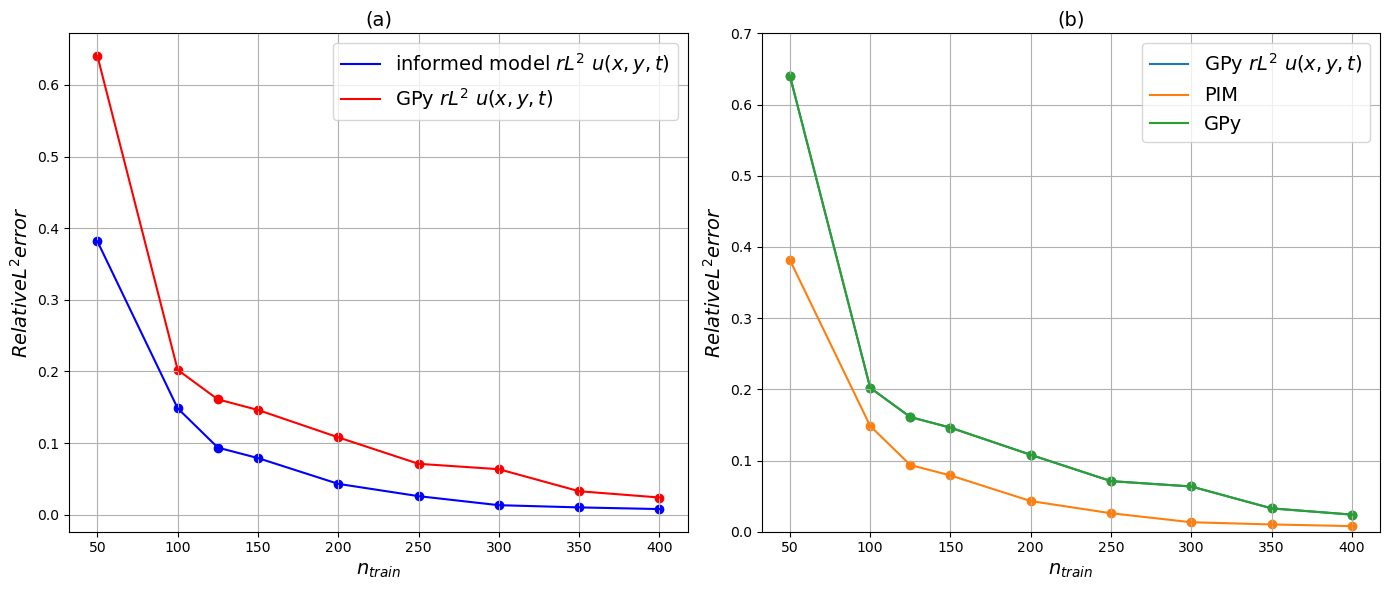

In [10]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
fontsize = 14
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize

ax[0].set_title('(a)', fontsize=fontsize)
ax[0].plot(n,errors_pim, label = "informed model $rL^2$ $u(x,y,t)$",color = "blue")
ax[0].scatter(n,errors_pim, color = "blue")
ax[0].plot(n,errors_gpy, label = "GPy $rL^2$ $u(x,y,t)$",color = "red")
ax[0].scatter(n,errors_gpy, color = "red")
ax[0].set_xlabel('$n_{train}$', fontsize=fontsize)
ax[0].set_ylabel('$Relative L^2 error$', fontsize=fontsize)
ax[0].legend()
ax[0].grid()
ax[1].set_title('(b)', fontsize=fontsize)
ax[1].plot(n,errors_gpy, label = "GPy $rL^2$ $u(x,y,t)$")
ax[1].scatter(n,errors_gpy)
ax[1].set_xlabel('$n_{train}$', fontsize=fontsize)
ax[1].set_ylabel('$Relative L^2 error$', fontsize=fontsize)
ax[1].legend()
ax[1].grid()
plt.tight_layout()
errors = np.array([errors_pim,errors_gpy,n])
print(errors)
#np.save("errors_no_bv.npy",errors)
 
plt.plot(n,errors_pim, label = "PIM")
plt.scatter(n,errors_pim)
plt.plot(n,errors_gpy, label = "GPy")
plt.scatter(n,errors_gpy)
plt.ylim(0,0.7)
plt.legend()


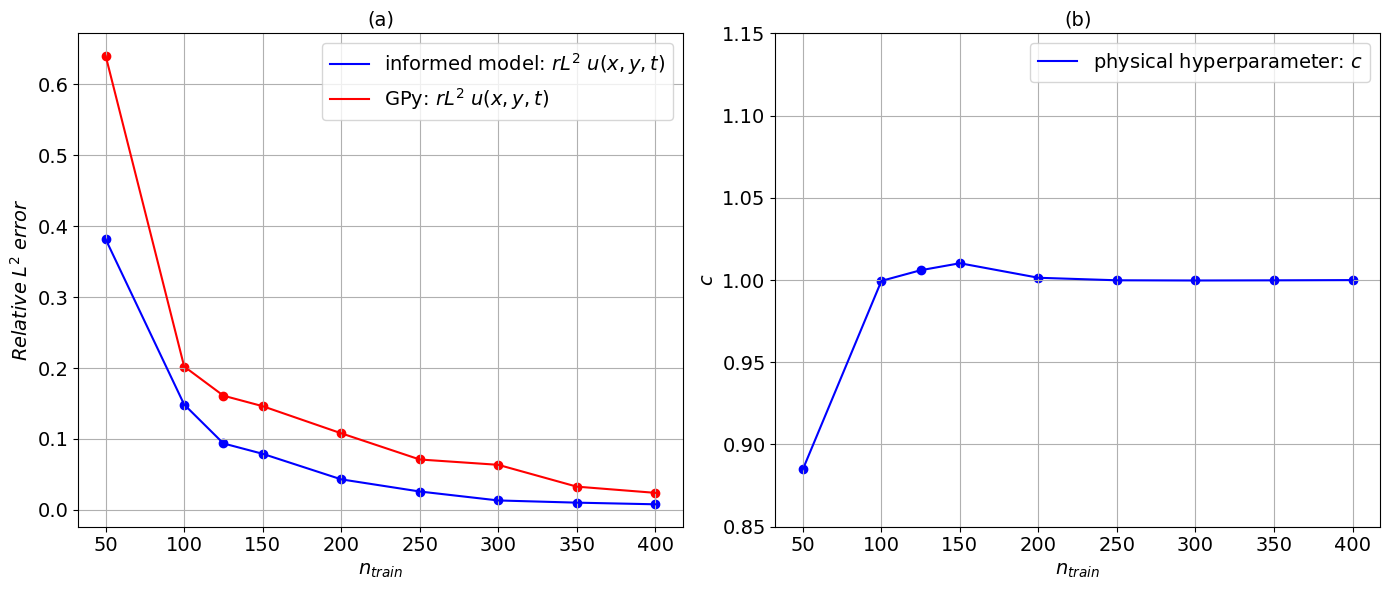

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# n = np.array(n)
# errors_50400 = np.array([errors_pim,errors_gpy,n],dtype=object)
# np.save('errors_50400.npy',errors_50400)
# np.save('model_params_50400.npy',model_params_pim)

errors_pim = np.load('errors_50400.npy',allow_pickle=True)[0]
errors_gpy = np.load('errors_50400.npy',allow_pickle=True)[1]
n = np.load('errors_50400.npy',allow_pickle=True)[2]
model_params_pim = np.load('model_params_50400.npy',allow_pickle=True)

fig, ax = plt.subplots(1,2,figsize=(14,6))
fontsize = 14
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize

ax[0].set_title('(a)', fontsize=fontsize)
ax[0].plot(n,errors_pim, label = "informed model: $rL^2$ $u(x,y,t)$",color = "blue")
ax[0].scatter(n,errors_pim, color = "blue")
ax[0].plot(n,errors_gpy, label = "GPy: $rL^2$ $u(x,y,t)$",color = "red")
ax[0].scatter(n,errors_gpy, color = "red")
ax[0].set_xlabel('$n_{train}$', fontsize=fontsize)
ax[0].set_ylabel('$Relative \\; L^2 \\;error$', fontsize=fontsize)
ax[0].legend()
ax[0].grid()
ax[1].set_title('(b)', fontsize=fontsize)
ax[1].plot(n,model_params_pim[:,3], label = "physical hyperparameter: $c$",color = "blue")
ax[1].scatter(n,model_params_pim[:,3], color = "blue")
ax[1].set_xlabel('$n_{train}$', fontsize=fontsize)
ax[1].set_ylabel('$c$', fontsize=fontsize)
ax[1].legend()
ax[1].grid()
ax[1].set_ylim(0.85,1.15)
plt.tight_layout()
plt.savefig('errors_50400.png', dpi=300, bbox_inches='tight') 


In [ ]:
import matplotlib.pyplot as plt
X_star = np.linspace(0,10,150).reshape(-1,1)
Y_star = np.linspace(0,10,150).reshape(-1,1)
T_star = np.linspace(0,10,150).reshape(-1,1)
X_star = np.hstack((X_star,Y_star,T_star))
pointx = np.array([[5.]])
pointy = np.array([[5.]])
pointt = np.array([[5.]])
point = np.hstack((pointx,pointy,pointt))
params = [1.,1.,1.,0.5]
kernel_kuu = model.k_uu(X_star,point,params)
kernel_kff = model.k_ff(X_star,point,params)
kernel_kuf = model.k_uf(X_star,point,params)
kernel_kfu = model.k_fu(X_star,point,params)

fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(X_star,kernel_kuu)
ax[0,0].set_title("k_uu")
ax[0,1].plot(X_star,kernel_kff)
ax[0,1].set_title("k_ff")
ax[1,0].plot(X_star,kernel_kuf)
ax[1,0].set_title("k_uf")
ax[1,1].plot(X_star,kernel_kfu)
ax[1,1].set_title("k_fu")
for i in range(2):
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].set_xlabel("x")
        ax[i,j].set_ylabel("k(x,x'=5)")
plt.tight_layout()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,t = model.X_u[:,0], model.X_u[:,1], model.X_u[:,2]

ax.scatter(x, y, t)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.savefig("training_points.png",bbox_inches='tight')
plt.show()
